In [28]:
# === Importação de Bibliotecas ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.neural_network import MLPRegressor
from scipy.stats import norm

from utils import plot_regression_diagnostics

# === Leitura do Dataset ===
df = pd.read_excel('Real estate valuation data set.xlsx')

# 1. Análise Exploratória

* Remover variável 'No' e manter as demais

In [2]:
df.head()

,No,X1 transaction date,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude,Y house price of unit area
0,1,2012.916667,32.0,84.87882,10,24.98298,121.54024,37.9
1,2,2012.916667,19.5,306.59470,9,24.98034,121.53951,42.2
2,3,2013.583333,13.3,561.98450,5,24.98746,121.54391,47.3
3,4,2013.500000,13.3,561.98450,5,24.98746,121.54391,54.8
4,5,2012.833333,5.0,390.56840,5,24.97937,121.54245,43.1


In [3]:
df.describe()

,No,X1 transaction date,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude,Y house price of unit area
count,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000
mean,207.500000,2013.148953,17.712560,1083.885689,4.094203,24.969030,121.533361,37.980193
std,119.655756,0.281995,11.392485,1262.109595,2.945562,0.012410,0.015347,13.606488
min,1.000000,2012.666667,0.000000,23.382840,0.000000,24.932070,121.473530,7.600000
25%,104.250000,2012.916667,9.025000,289.324800,1.000000,24.963000,121.528085,27.700000
50%,207.500000,2013.166667,16.100000,492.231300,4.000000,24.971100,121.538630,38.450000
75%,310.750000,2013.416667,28.150000,1454.279000,6.000000,24.977455,121.543305,46.600000
max,414.000000,2013.583333,43.800000,6488.021000,10.000000,25.014590,121.566270,117.500000


In [4]:
print(f"Forma do dataset: {df.shape}")
print(f"Número de linhas: {df.shape[0]}")
print(f"Número de colunas: {df.shape[1]}")
null_counts = df.isnull().sum()
print("Valores nulos por coluna:")
print(null_counts)
print("\nNomes das colunas e seus tipos de dados:")
for col in df.columns:
    print(f"{col}: {df[col].dtype}")


Forma do dataset: (414, 8)
Número de linhas: 414
Número de colunas: 8
Valores nulos por coluna:
No                                        0
X1 transaction date                       0
X2 house age                              0
X3 distance to the nearest MRT station    0
X4 number of convenience stores           0
X5 latitude                               0
X6 longitude                              0
Y house price of unit area                0
dtype: int64

Nomes das colunas e seus tipos de dados:
No: int64
X1 transaction date: float64
X2 house age: float64
X3 distance to the nearest MRT station: float64
X4 number of convenience stores: int64
X5 latitude: float64
X6 longitude: float64
Y house price of unit area: float64


Colunas numéricas: ['No', 'X1 transaction date', 'X2 house age', 'X3 distance to the nearest MRT station', 'X4 number of convenience stores', 'X5 latitude', 'X6 longitude', 'Y house price of unit area']


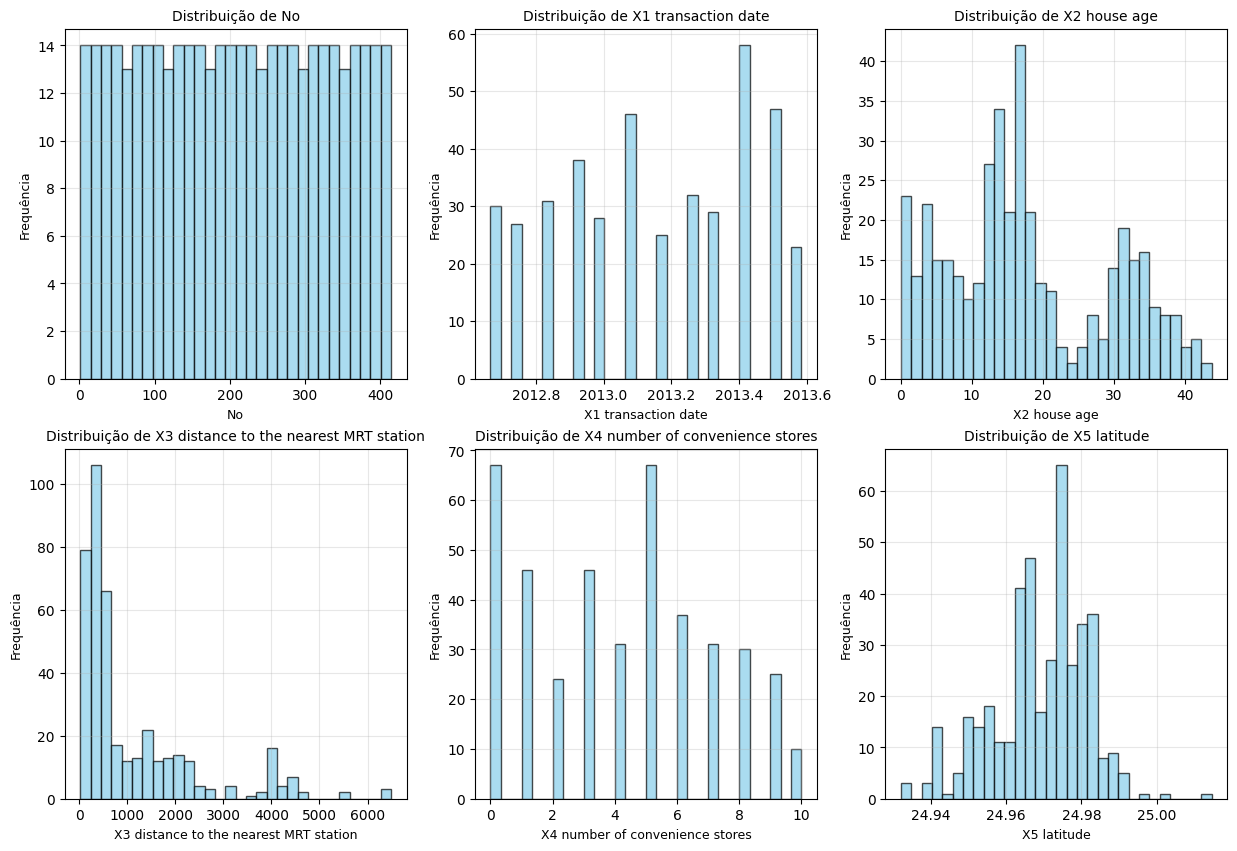

In [5]:
numeric_columns = df.select_dtypes(include=[np.number]).columns
print(f"Colunas numéricas: {list(numeric_columns)}")

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

for i, col in enumerate(numeric_columns):
    if i < len(axes):
        axes[i].hist(df[col], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
        axes[i].set_title(f'Distribuição de {col}', fontsize=10)
        axes[i].set_xlabel(col, fontsize=9)
        axes[i].set_ylabel('Frequência', fontsize=9)
        axes[i].grid(True, alpha=0.3)

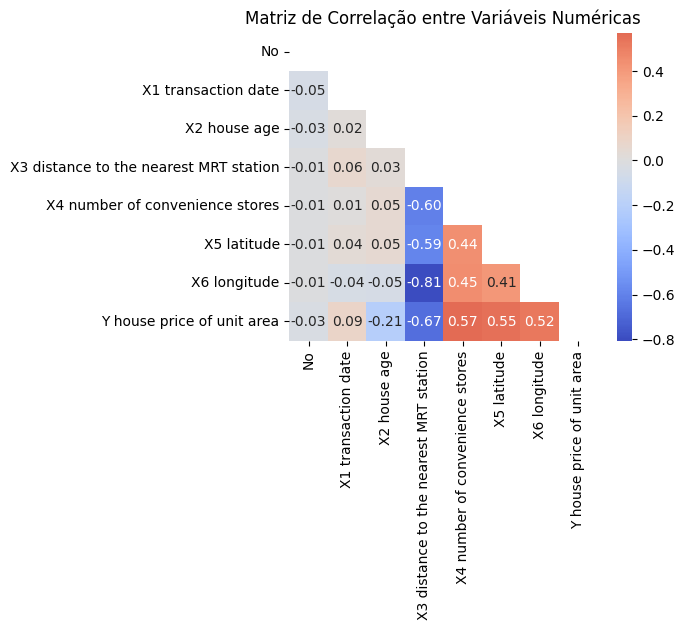

In [6]:
correlation_matrix = df[numeric_columns].corr()

plt.figure(figsize=(5, 4))
mask = np.triu(np.ones_like(correlation_matrix))
sns.heatmap(correlation_matrix, 
            mask=mask,
            annot=True, 
            cmap='coolwarm', 
            center=0,
            square=True,
            fmt='.2f');
plt.title('Matriz de Correlação entre Variáveis Numéricas')
plt.show()


# 2. Implementação de modelos

In [7]:
X = df.drop('No', axis = 1).iloc[:, :-1]  # Todas as colunas exceto a última
y = df.iloc[:, -1]   # Última coluna (preço)

# Dividir em treino (80%) e teste (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=99)

# Normalizar os dados (importante para redes neurais, mas para regressão linear não é necessário)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Treino: {X_train.shape}")
print(f"Teste: {X_test.shape}")

Treino: (331, 6)
Teste: (83, 6)


Coeficiente de correlação de Pearson (Treino): 0.7581
R² (Treino): 0.5747
Coeficiente de correlação de Pearson (Teste): 0.7813
R² (Teste): 0.6094


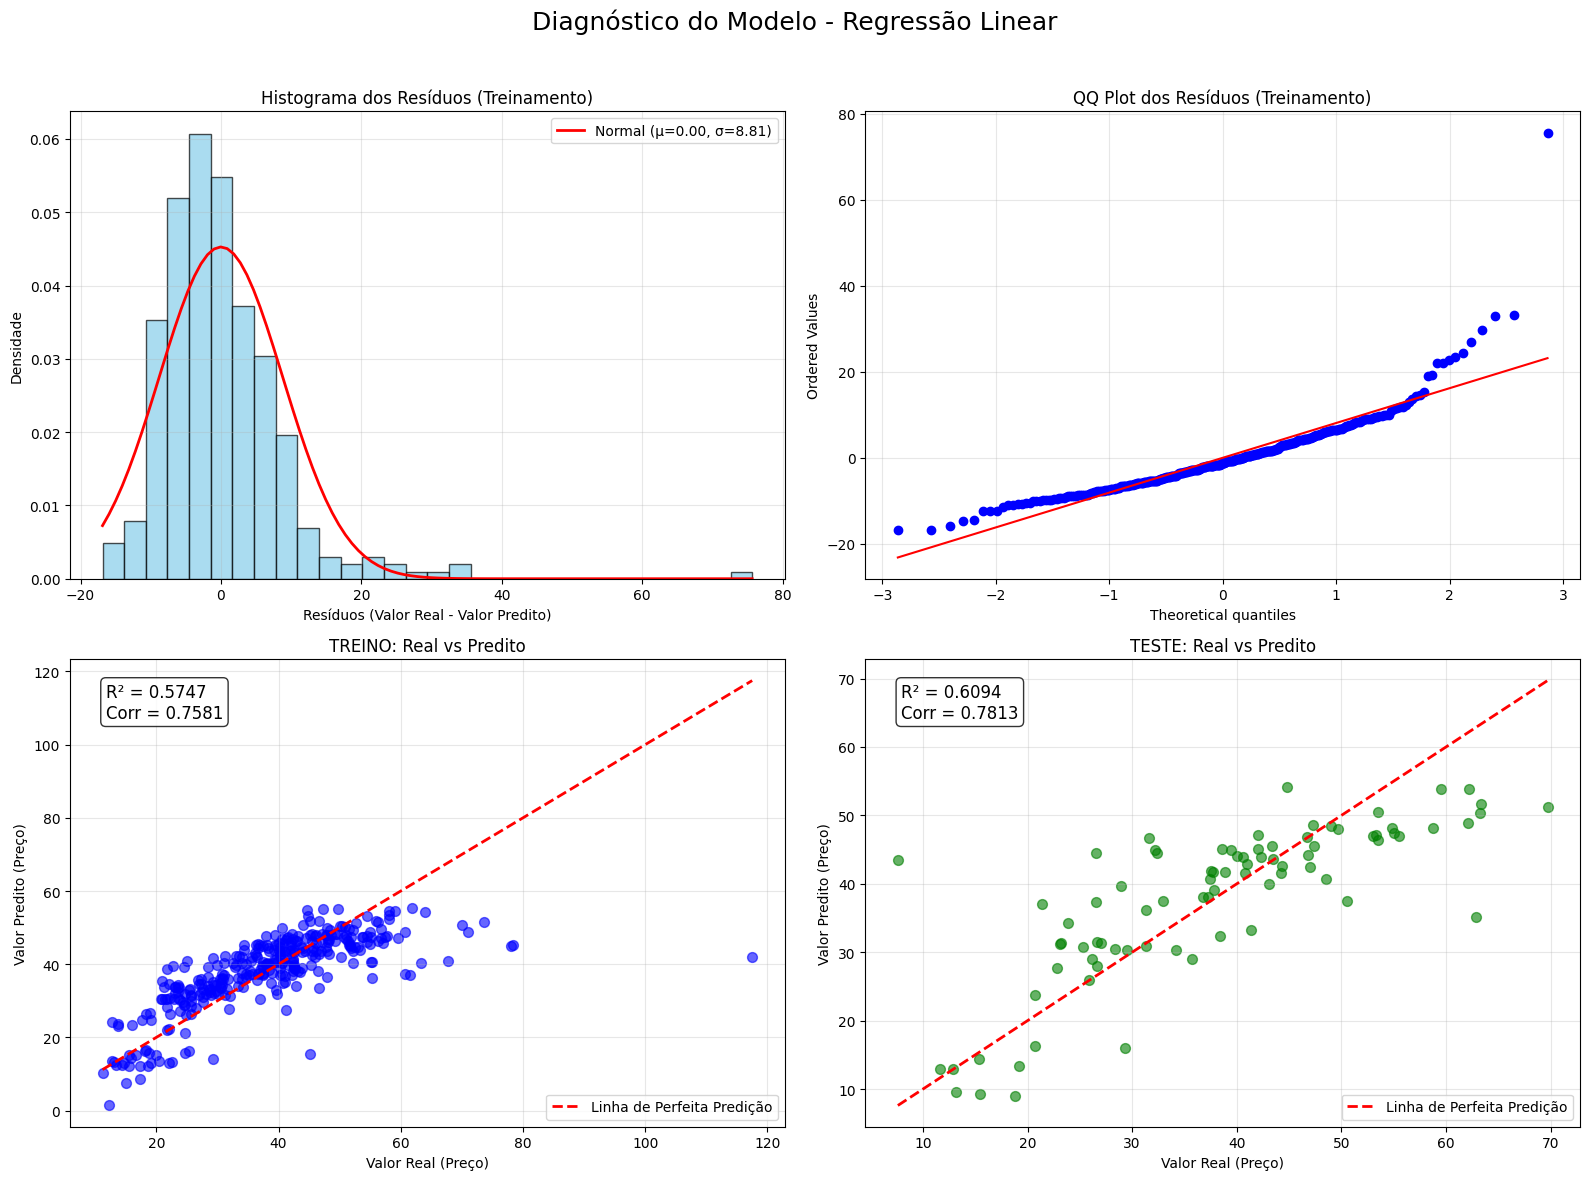

In [16]:
# Regressão Linear
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_train_pred = lr_model.predict(X_train)
lr_test_pred = lr_model.predict(X_test)
lr_corr_train, lr_corr_test, lr_r2_train, lr_r2_test = plot_regression_diagnostics(y_train = y_train, y_train_pred = lr_train_pred, y_test = y_test, y_test_pred = lr_test_pred, title = 'Regressão Linear')



Coeficiente de correlação de Pearson (Treino): 0.8366
R² (Treino): 0.6999
Coeficiente de correlação de Pearson (Teste): 0.8408
R² (Teste): 0.7065


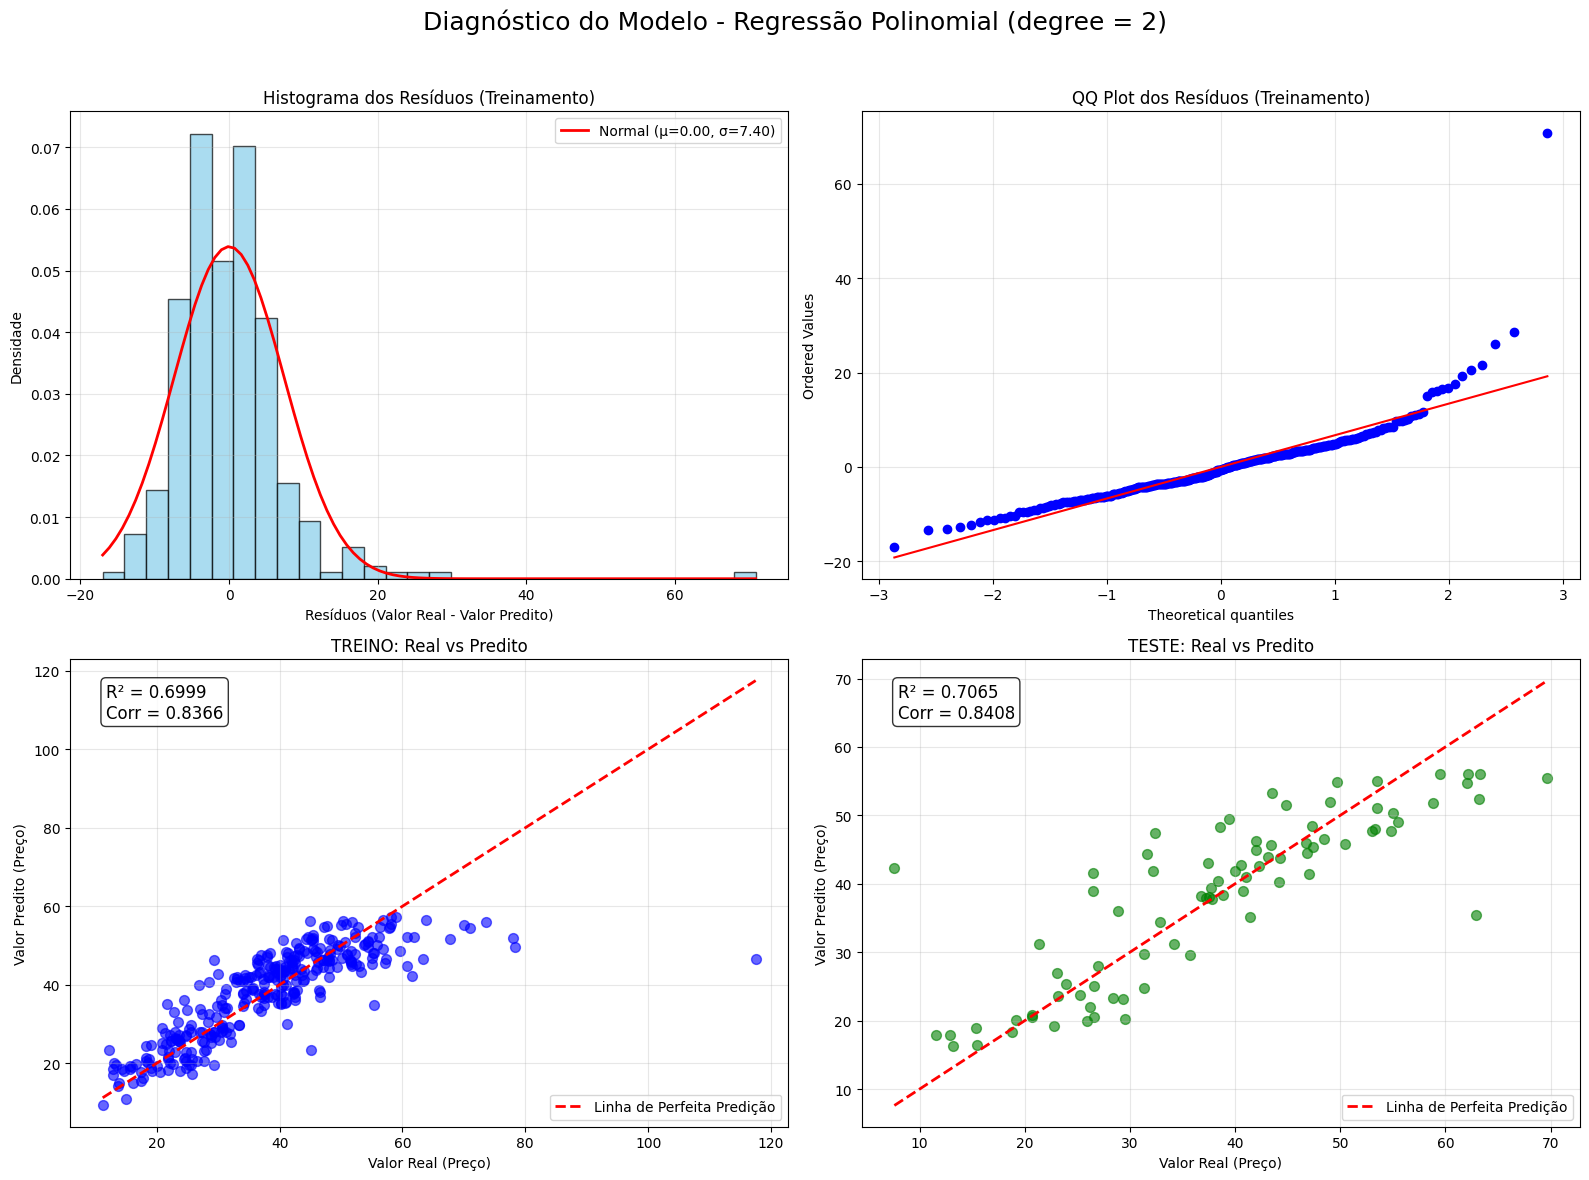

In [17]:
#Regressão Polinomial

poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)
poly_model = LinearRegression()
poly_model.fit(X_train_poly, y_train)
poly_train_pred = poly_model.predict(X_train_poly)
poly_test_pred = poly_model.predict(X_test_poly)

lr_poly_2_corr_train, lr_poly_2_corr_test, lr_poly_2_r2_train, lr_poly_2_r2_test = plot_regression_diagnostics(y_train = y_train, y_train_pred = poly_train_pred, y_test = y_test, y_test_pred = poly_test_pred, title = 'Regressão Polinomial (degree = 2)')

Coeficiente de correlação de Pearson (Treino): 0.8781
R² (Treino): 0.7711
Coeficiente de correlação de Pearson (Teste): 0.8069
R² (Teste): 0.6454


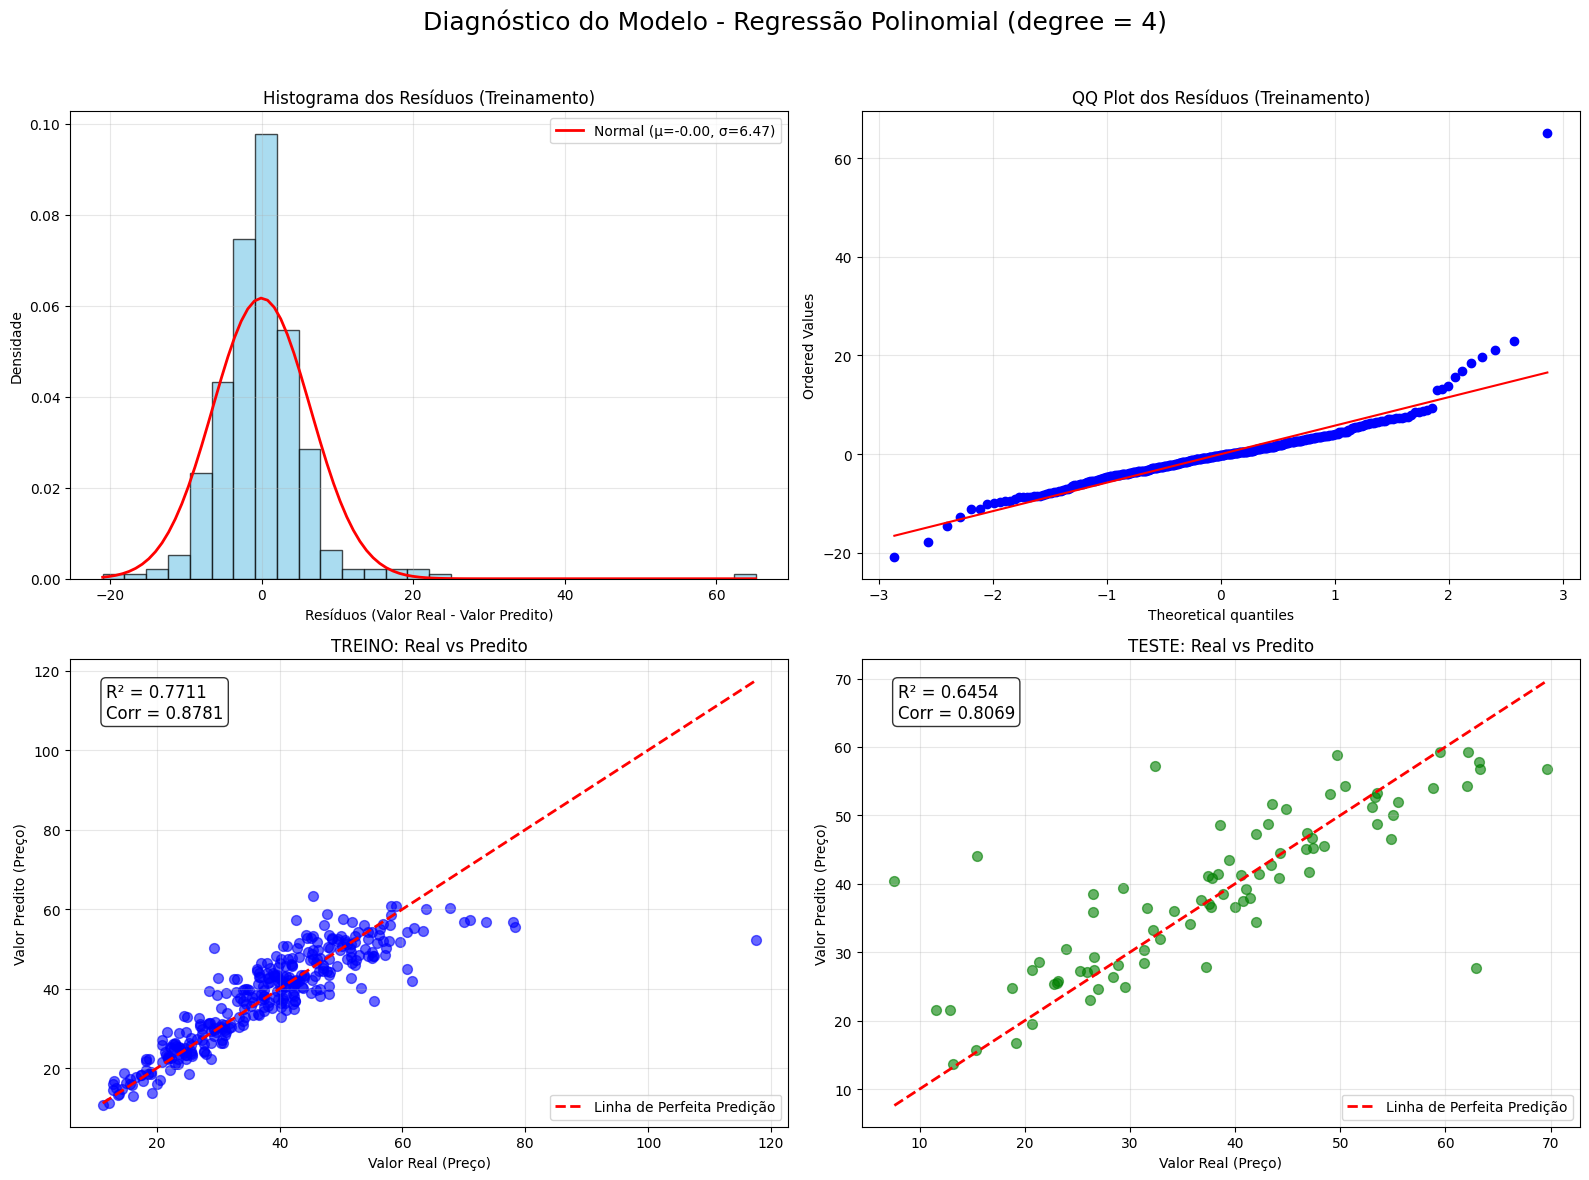

In [18]:
#Regressão Polinomial
poly = PolynomialFeatures(degree=4)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)
poly_model = LinearRegression()
poly_model.fit(X_train_poly, y_train)
poly_train_pred = poly_model.predict(X_train_poly)
poly_test_pred = poly_model.predict(X_test_poly)
lr_poly_4_corr_train, lr_poly_4_corr_test, lr_poly_4_r2_train, lr_poly_4_r2_test = plot_regression_diagnostics(y_train = y_train, y_train_pred = poly_train_pred, y_test = y_test, y_test_pred = poly_test_pred, title = 'Regressão Polinomial (degree = 4)')

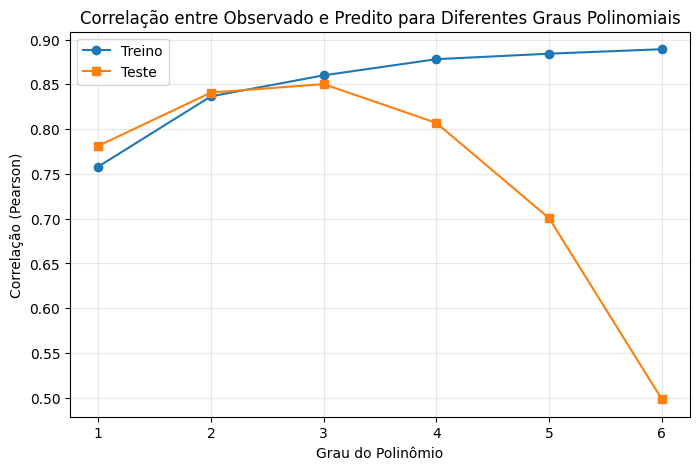

In [11]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr

correlations_train = []
correlations_test = []
degrees = range(1, 7)

for degree in degrees:
    poly = PolynomialFeatures(degree=degree)
    X_train_poly = poly.fit_transform(X_train)
    X_test_poly = poly.transform(X_test)
    model = LinearRegression()
    model.fit(X_train_poly, y_train)
    y_train_pred = model.predict(X_train_poly)
    y_test_pred = model.predict(X_test_poly)
    corr_train, _ = pearsonr(y_train, y_train_pred)
    corr_test, _ = pearsonr(y_test, y_test_pred)
    correlations_train.append(corr_train)
    correlations_test.append(corr_test)

plt.figure(figsize=(8, 5))
plt.plot(degrees, correlations_train, marker='o', label='Treino')
plt.plot(degrees, correlations_test, marker='s', label='Teste')
plt.xlabel('Grau do Polinômio')
plt.ylabel('Correlação (Pearson)')
plt.title('Correlação entre Observado e Predito para Diferentes Graus Polinomiais')
plt.xticks(degrees)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


/Users/guilherme/Documents/GitHub/inteligencia_computacional_aplicada/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Coeficiente de correlação de Pearson (Treino): 0.3433
R² (Treino): -0.0184
Coeficiente de correlação de Pearson (Teste): 0.3198
R² (Teste): -0.0180


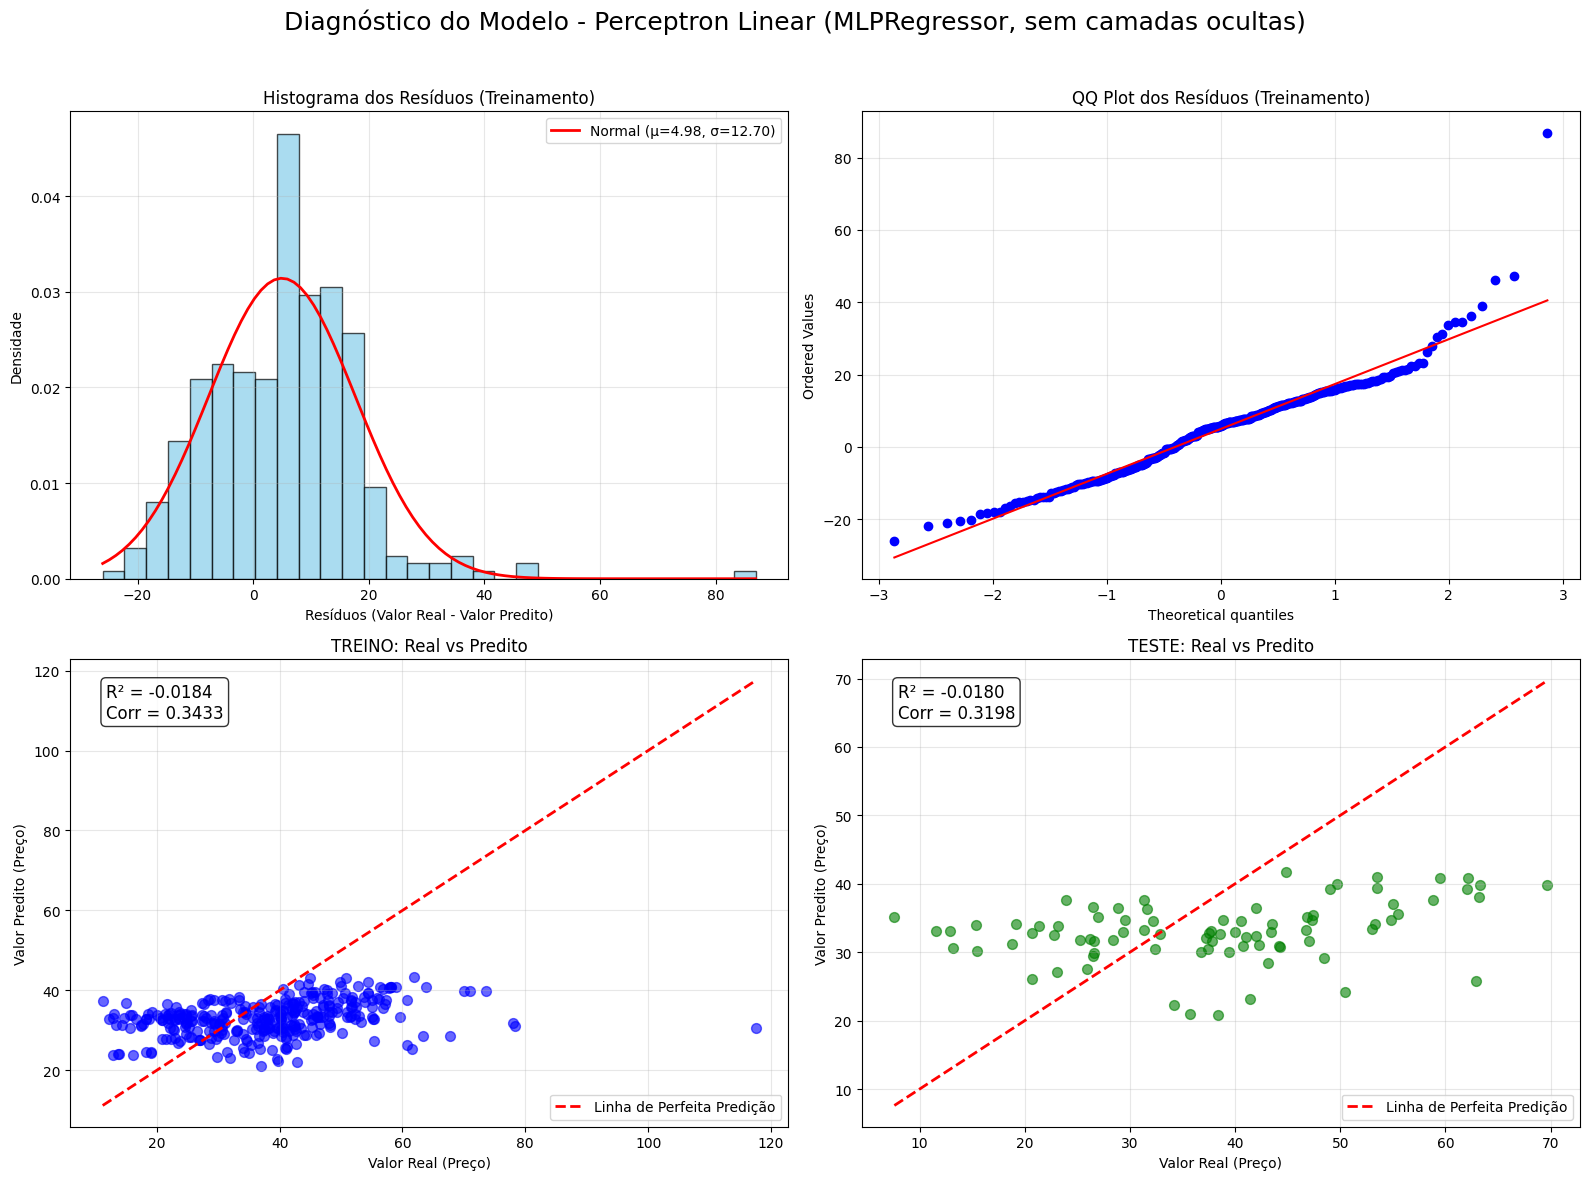

In [19]:
#  Perceptron logistico (sem camadas ocultas, saída linear)
mlp = MLPRegressor(hidden_layer_sizes=(), activation='identity', max_iter=1000, random_state=11)

# Treinamento do modelo
mlp.fit(X_train, y_train)

# Predição nos conjuntos de treino e teste
y_train_pred_mlp = mlp.predict(X_train)
y_test_pred_mlp = mlp.predict(X_test)

# Avaliação do modelo
ps_mlp_corr_train, ps_mlp_corr_test, ps_mlp_r2_train, ps_mlp_r2_test = plot_regression_diagnostics(
    y_train=y_train, 
    y_train_pred=y_train_pred_mlp, 
    y_test=y_test, 
    y_test_pred=y_test_pred_mlp, 
    title='Perceptron Linear (MLPRegressor, sem camadas ocultas)'
)



/Users/guilherme/Documents/GitHub/inteligencia_computacional_aplicada/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Coeficiente de correlação de Pearson (Treino): 0.7723
R² (Treino): 0.5959
Coeficiente de correlação de Pearson (Teste): 0.7852
R² (Teste): 0.6151


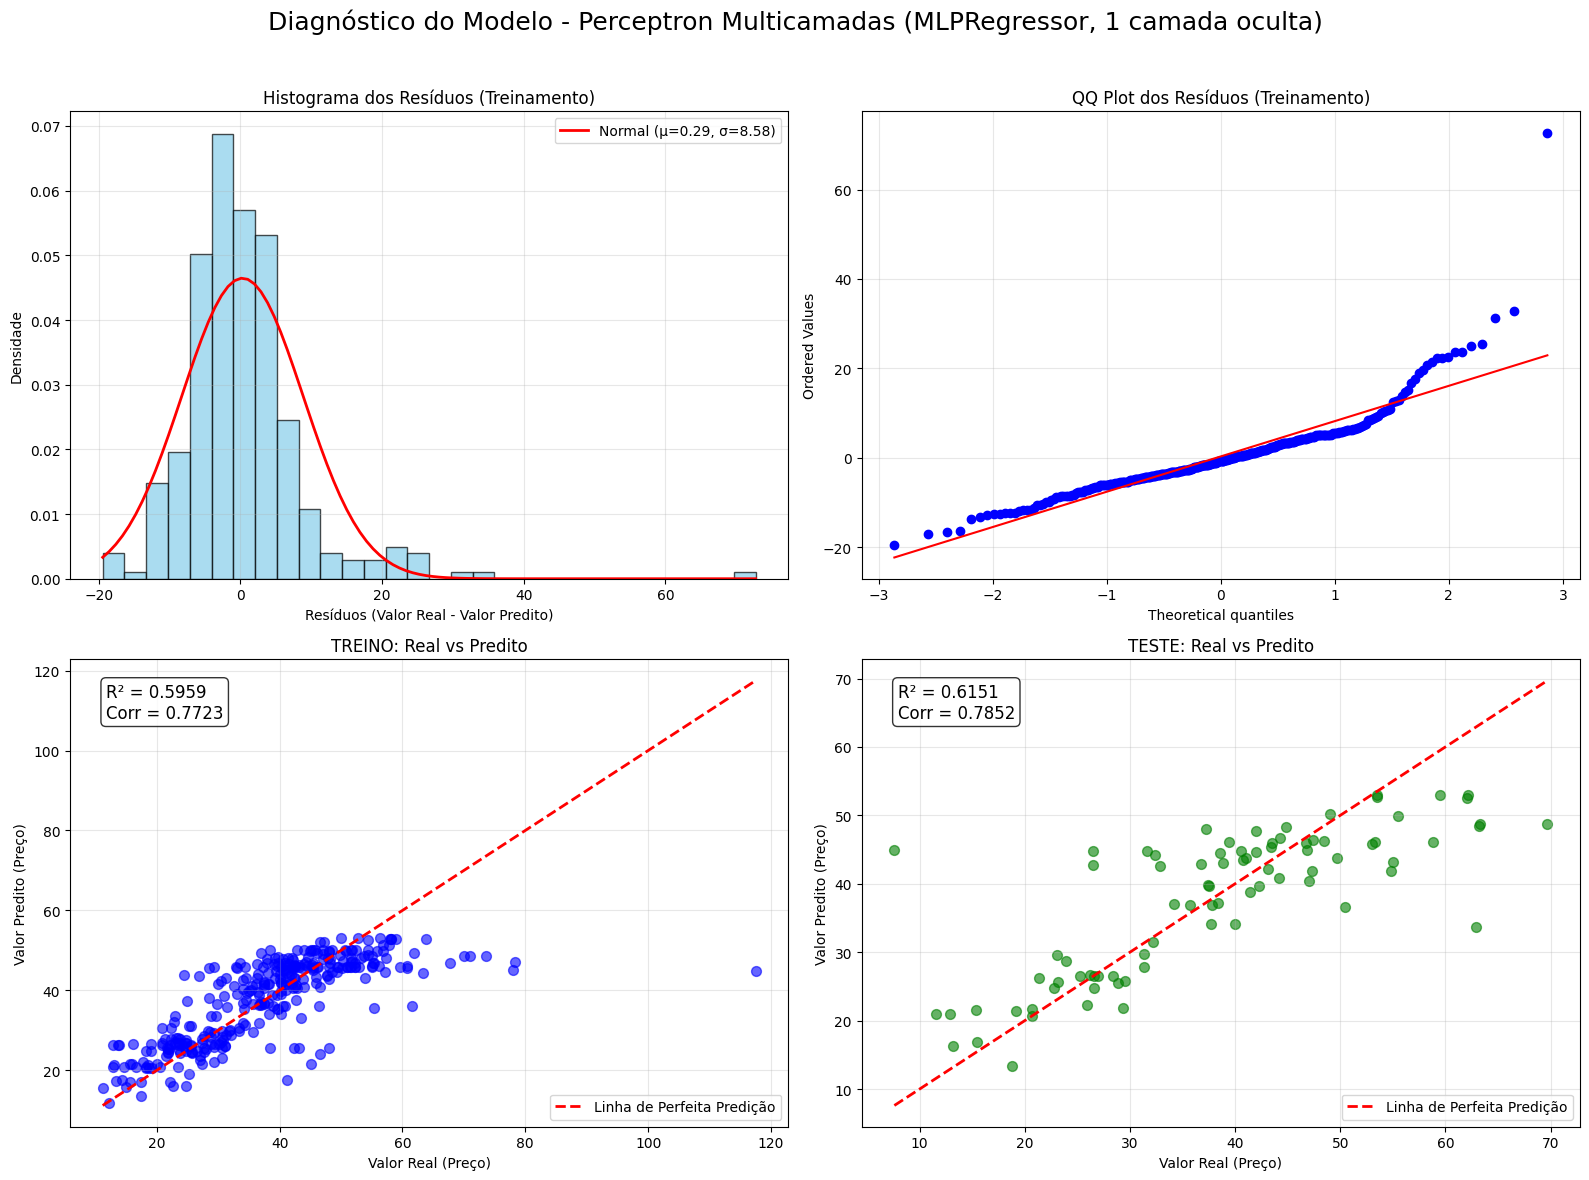

In [20]:
# Perceptron Multicamadas (MLPRegressor) com 1 camada oculta
mlp = MLPRegressor(hidden_layer_sizes=(10,), activation='relu', max_iter=1000, random_state=11)

# Treinamento do modelo
mlp.fit(X_train, y_train)

# Predição nos conjuntos de treino e teste
y_train_pred_mlp = mlp.predict(X_train)
y_test_pred_mlp = mlp.predict(X_test)

# Avaliação do modelo
mlp_1_corr_train, mlp_1_corr_test, mlp_1_r2_train, mlp_1_r2_test = plot_regression_diagnostics(
    y_train=y_train, 
    y_train_pred=y_train_pred_mlp, 
    y_test=y_test, 
    y_test_pred=y_test_pred_mlp, 
    title='Perceptron Multicamadas (MLPRegressor, 1 camada oculta)'
)


/Users/guilherme/Documents/GitHub/inteligencia_computacional_aplicada/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Coeficiente de correlação de Pearson (Treino): 0.7643
R² (Treino): 0.5842
Coeficiente de correlação de Pearson (Teste): 0.7795
R² (Teste): 0.6074


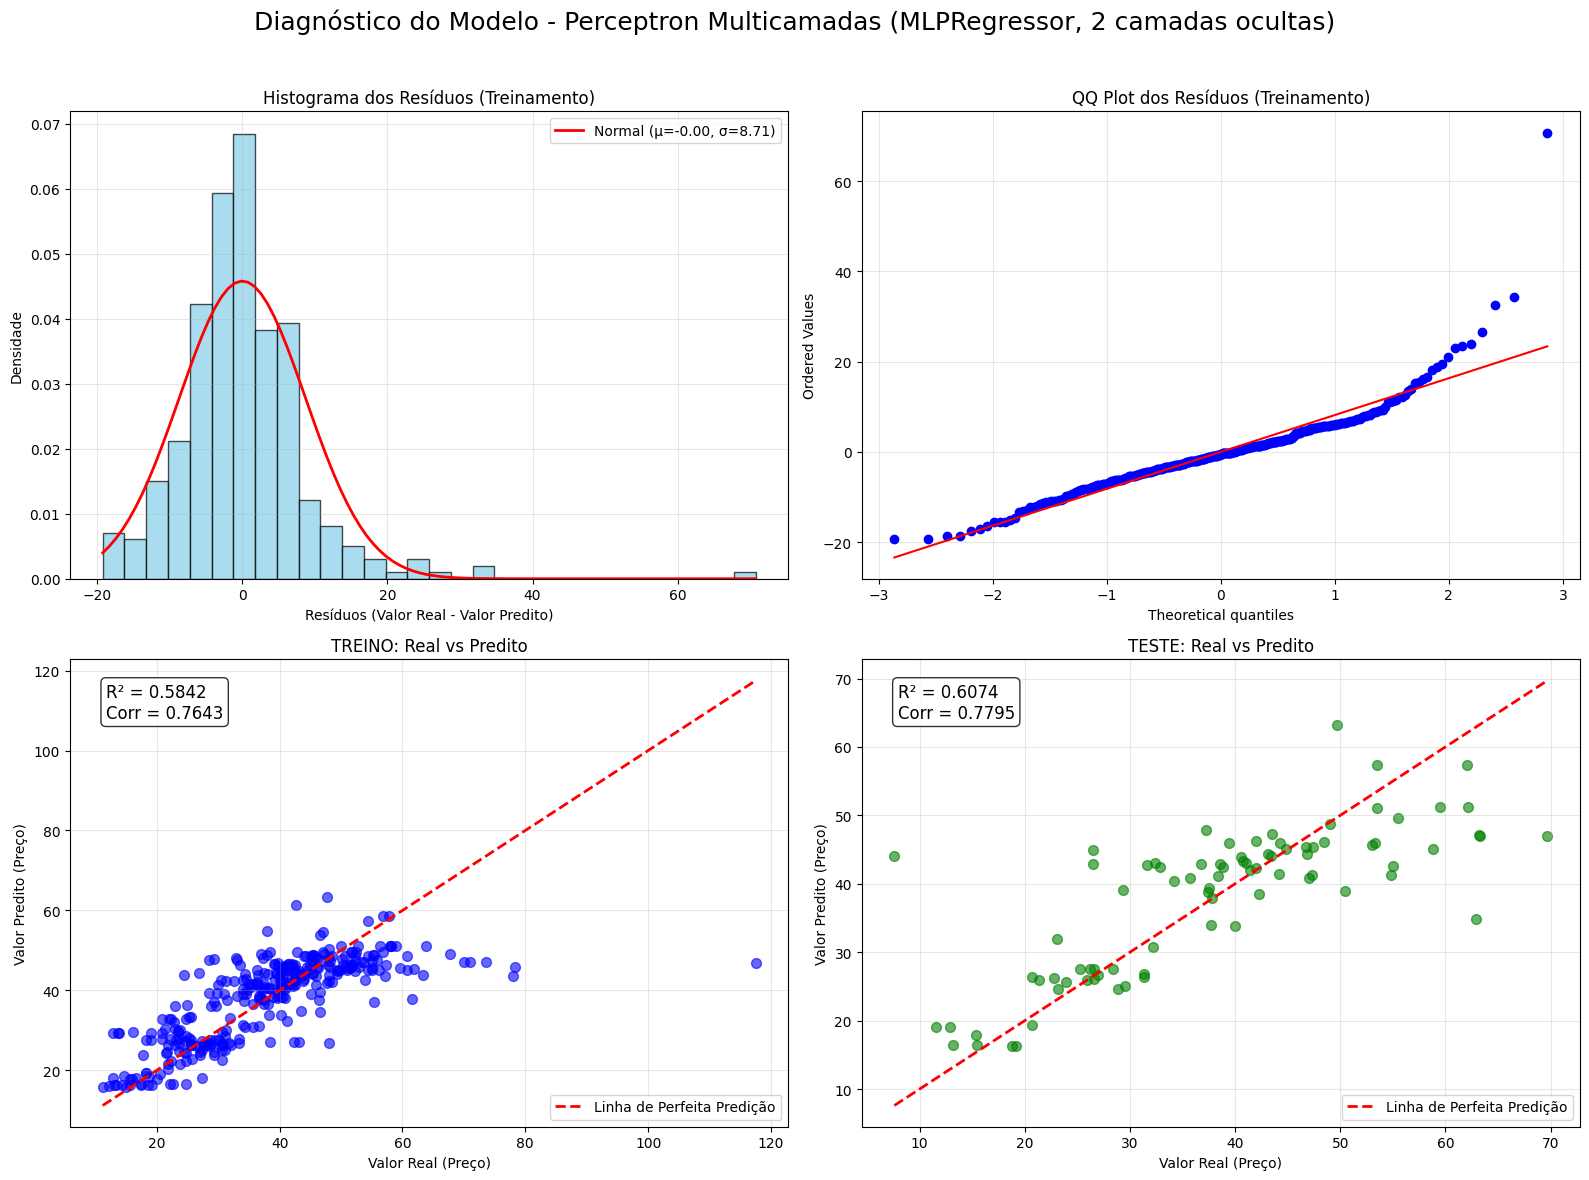

In [21]:
# Perceptron Multicamadas (MLPRegressor) com 2 camadas ocultas
mlp = MLPRegressor(hidden_layer_sizes=(10, 5), activation='relu', max_iter=1000, random_state=11)

# Treinamento do modelo
mlp.fit(X_train, y_train)

# Predição nos conjuntos de treino e teste
y_train_pred_mlp = mlp.predict(X_train)
y_test_pred_mlp = mlp.predict(X_test)

# Avaliação do modelo

mlp_2_corr_train, mlp_2_corr_test, mlp_2_r2_train, mlp_2_r2_test = plot_regression_diagnostics(
    y_train=y_train, 
    y_train_pred=y_train_pred_mlp, 
    y_test=y_test, 
    y_test_pred=y_test_pred_mlp, 
    title='Perceptron Multicamadas (MLPRegressor, 2 camadas ocultas)'
)


Coeficiente de correlação de Pearson (Treino): 0.7484
R² (Treino): 0.5524
Coeficiente de correlação de Pearson (Teste): 0.7659
R² (Teste): 0.5754


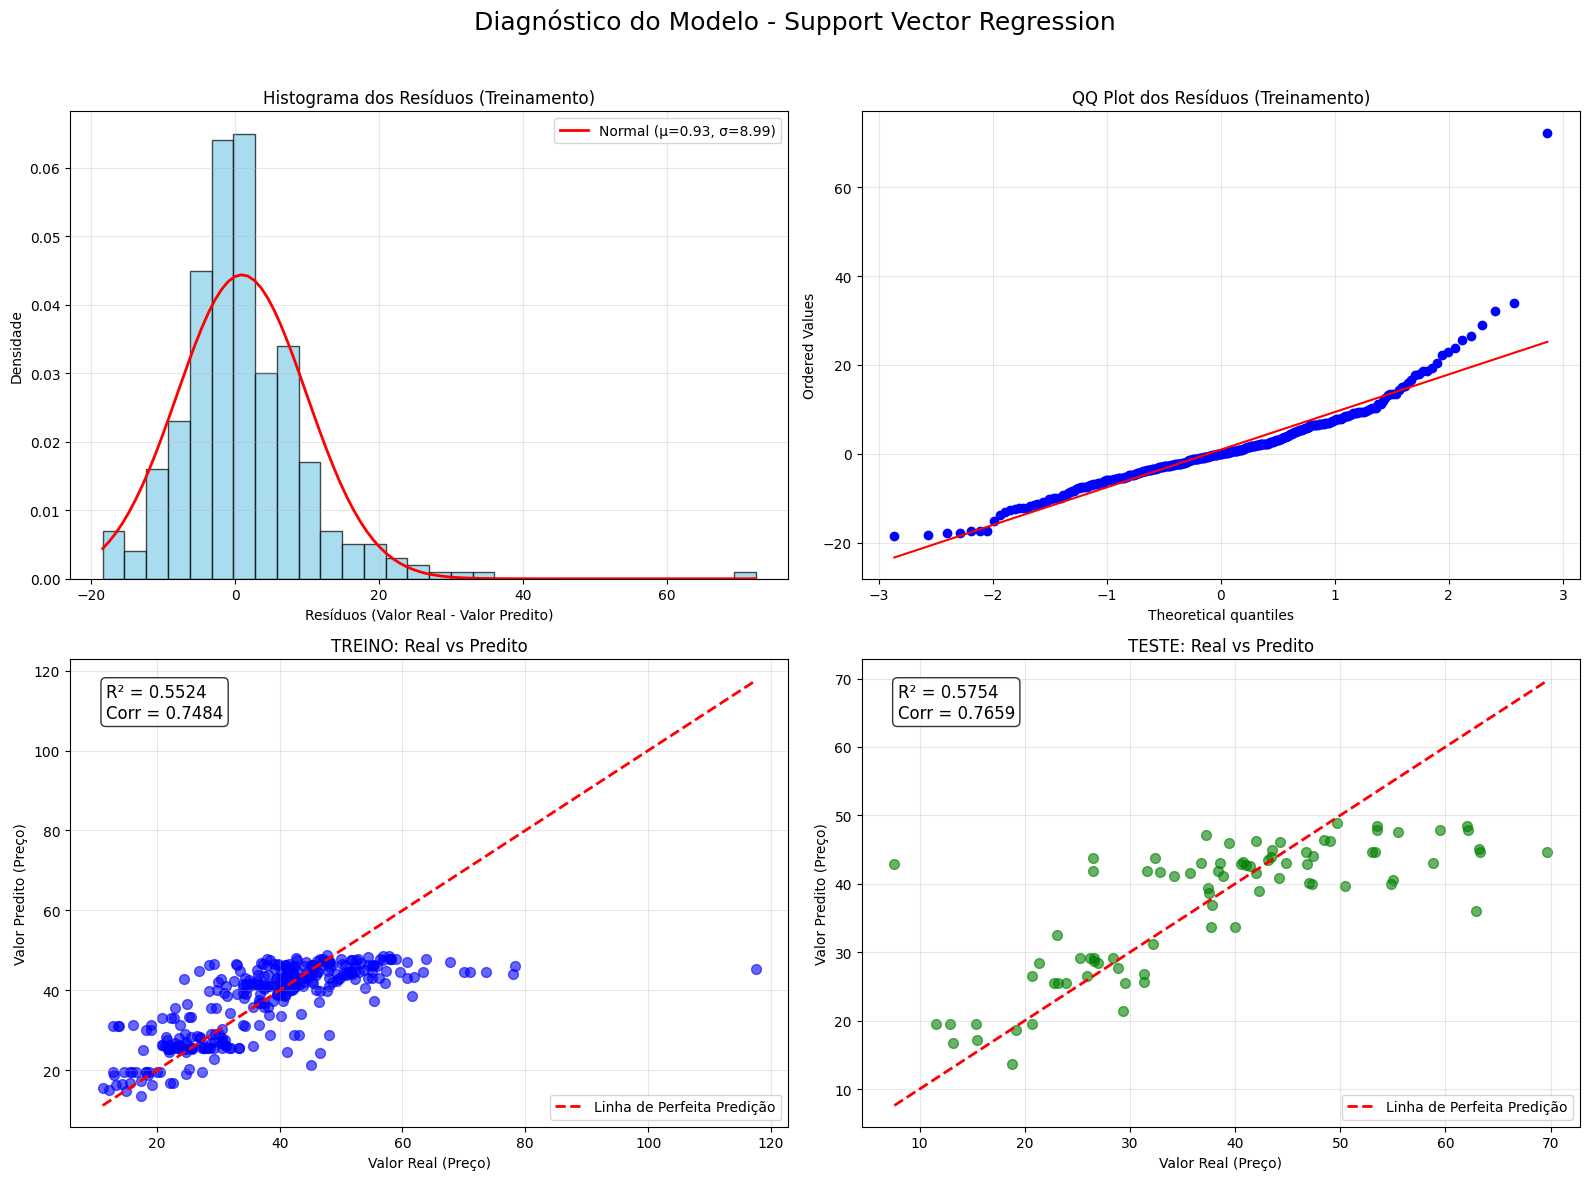

In [27]:
# SVR - Support Vector Regression
from sklearn.svm import SVR

svr = SVR(kernel='rbf', C=10, epsilon=0.1)
svr.fit(X_train, y_train)

y_train_pred_svr = svr.predict(X_train)
y_test_pred_svr = svr.predict(X_test)

svr_corr_train, svr_corr_test, svr_r2_train, svr_r2_test = plot_regression_diagnostics(
    y_train=y_train, 
    y_train_pred=y_train_pred_svr, 
    y_test=y_test, 
    y_test_pred=y_test_pred_svr, 
    title='Support Vector Regression'
)